<a href="https://www.kaggle.com/code/martastangierska/sales-data-analysis-and-processing?scriptVersionId=100491032" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# SALES DATA ANALYSIS AND PROCESSING

## Data source
The sales data comes from Kaggle 'Store Sales - Time Series Forecasting' competition, available here: https://www.kaggle.com/competitions/store-sales-time-series-forecasting

## Goal of the competition
In this “getting started” competition, you’ll use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer.

## This notebook
In this notebook, data is imported, pre-processed and analysed. 

Following methods and plots are employed to analyse the data:
- Interactive map of the shops, to understand the geographical distribution of the shops
- Line plots of (a) oil price data, (b) sales vs oil price data, to understand trends in the data
- Autocorrelation, autocorrelation function and partial autocorrelation plots, to understand trends, seasonality, lags etc.
- Predictions using autoregression

## Credits
This notebook is partially based on this notebook by ALEKSANDR MOROZOV123 user on Kaggle, link here: 
- KAGGLE:https://www.kaggle.com/code/aleksandrmorozov123/time-series-forecasting-with-python
- GITHUB: https://github.com/AleksandrMorozov123/Competition-on-kaggle-/blob/f82152769d8e1e056d82a0ca89c87d19d7cd5941/time-series-forecasting-with-python.ipynb

Other credits & useful links:
- Creating interactive notebook: https://vverde.github.io/blob/interactivechoropleth.html
- Autocorrelation & partial correlation: https://statisticsbyjim.com/time-series/autocorrelation-partial-autocorrelation/


# IMPORT LIBRARIES

In [1]:
import geopandas as gpd
import folium 
import matplotlib.pyplot as plt
import pandas as pd

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import math
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
ls

__notebook__.ipynb


# DATA IMPORTS

In [3]:
holidays_data = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv')
print(holidays_data.shape)
holidays_data['date'] = pd.to_datetime(holidays_data['date'], format = '%Y.%m.%d')
holidays_data.head()

(350, 6)


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [4]:
transactions_data = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv')
print(transactions_data.shape)
transactions_data['date'] = pd.to_datetime(transactions_data['date'], format = '%Y.%m.%d')
transactions_data.head()

(83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [5]:
oil_data = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
oil_data['date'] = pd.to_datetime(oil_data['date'], format = '%Y.%m.%d')
print(oil_data.shape)
#oil_data[oil_data['date']<'2017-09-01']
oil_data.head()

(1218, 2)


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [6]:
stores_data = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv')
print(stores_data.shape)
stores_data.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
train_data = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
print(train_data.shape)
train_data['date'] = pd.to_datetime(train_data['date'], format = '%Y.%m.%d')
train_data['Year Month'] = train_data['date'].apply(lambda x:x.strftime('%Y %m'))
train_data = pd.merge(left=train_data,right=stores_data, on='store_nbr',how='left')
train_data.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion,Year Month,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013 01,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,2013 01,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,2013 01,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013 01,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,2013 01,Quito,Pichincha,D,13


# Check for empty rows and drop missing values

In [8]:
holidays_data.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [9]:
transactions_data.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [10]:
stores_data.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [11]:
oil_data.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [12]:
# Dropping missing values
print(oil_data.shape)
oil_data = oil_data.dropna()
print(oil_data.shape)
oil_data.count()

(1218, 2)
(1175, 2)


date          1175
dcoilwtico    1175
dtype: int64

# EXPLORATORY DATA ANALYSIS

## PLOTTING INTERACTIVE MAP OF THE SHOPS

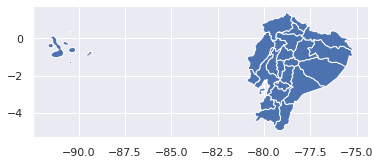

In [13]:
ec_geo = '../input/stores-sales-ecuador/provs_ec.json'
geojson = gpd.read_file(ec_geo)
geojson.plot(figsize=(6, 6))
plt.show()

In [14]:
equador = folium.Map(location=[-1.831239, -78.183403], zoom_start=7, tiles='cartodbpositron')
equador

In [15]:
for _, r in geojson.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['dpa_despro']).add_to(geo_j)
    geo_j.add_to(equador)
equador

In [16]:
stores_data = stores_data.groupby(['state'],as_index=False).count()
stores_data['state'] = stores_data['state'].str.upper()

In [17]:
geojson.head()

,id_prov,dpa_provin,dpa_despro,dpa_valor,dpa_anio,rei_codigo,ren_codigo,pee_codigo,codigo,codigo_1,...,promedio_e,pobres_nbi,no_pobres,pob_nopob_,densidad,edad_media,cartodb_id,created_at,updated_at,geometry
0,1,01,AZUAY,0,2012,05,01,593,1,1,...,9.01,338073,361875,699948,85.70,28.85,1,2015-04-20T23:35:12+00:00,2015-04-21T16:01:08+00:00,"POLYGON ((-78.56954 -2.55865, -78.55638 -2.560..."
1,2,02,BOLIVAR,0,2012,02,01,593,2,2,...,7.79,139044,43098,182142,46.55,29.24,2,2015-04-20T23:35:12+00:00,2015-04-21T16:01:30+00:00,"POLYGON ((-78.86209 -1.19140, -78.93792 -1.360..."
2,3,03,CANAR,0,2012,05,01,593,3,3,...,7.75,150549,72654,223203,71.58,28.58,3,2015-04-20T23:35:12+00:00,2015-04-21T16:01:49+00:00,"POLYGON ((-78.56954 -2.55865, -78.61701 -2.628..."
3,4,04,CARCHI,0,2012,04,01,593,4,4,...,8.36,93049,69728,162777,43.52,29.74,4,2015-04-20T23:35:12+00:00,2015-04-21T16:01:54+00:00,"POLYGON ((-77.53187 0.65236, -77.65643 0.64755..."
4,5,05,COTOPAXI,0,2012,02,01,593,5,5,...,7.82,304474,101152,405626,66.99,28.04,5,2015-04-20T23:35:12+00:00,2015-04-21T16:02:12+00:00,"POLYGON ((-78.42185 -0.71691, -78.39141 -0.748..."


In [18]:
#GEOJSON PROCESSING 
geojson = geojson.to_crs(epsg = 2263)
geojson['centroid'] = geojson.centroid
geojson.drop(['created_at','updated_at'],inplace=True, axis=1)
geojson = pd.merge(left=geojson,right=stores_data,left_on='dpa_despro',right_on='state',how='left')
geojson['store_nbr'] = geojson['store_nbr'].fillna(0)
geojson = geojson.to_crs(epsg = 4326)
geojson['centroid'] = geojson['centroid'].to_crs(epsg=4326)
geojson.head()

,id_prov,dpa_provin,dpa_despro,dpa_valor,dpa_anio,rei_codigo,ren_codigo,pee_codigo,codigo,codigo_1,...,densidad,edad_media,cartodb_id,geometry,centroid,state,store_nbr,city,type,cluster
0,1,01,AZUAY,0,2012,05,01,593,1,1,...,85.70,28.85,1,"POLYGON ((-78.56954 -2.55865, -78.55638 -2.560...",POINT (-79.16506 -3.00840),AZUAY,3.0,3.0,3.0,3.0
1,2,02,BOLIVAR,0,2012,02,01,593,2,2,...,46.55,29.24,2,"POLYGON ((-78.86209 -1.19140, -78.93792 -1.360...",POINT (-79.10225 -1.59228),BOLIVAR,1.0,1.0,1.0,1.0
2,3,03,CANAR,0,2012,05,01,593,3,3,...,71.58,28.58,3,"POLYGON ((-78.56954 -2.55865, -78.61701 -2.628...",POINT (-79.01109 -2.54392),NaN,0.0,NaN,NaN,NaN
3,4,04,CARCHI,0,2012,04,01,593,4,4,...,43.52,29.74,4,"POLYGON ((-77.53187 0.65236, -77.65643 0.64755...",POINT (-78.07403 0.76606),NaN,0.0,NaN,NaN,NaN
4,5,05,COTOPAXI,0,2012,02,01,593,5,5,...,66.99,28.04,5,"POLYGON ((-78.42185 -0.71691, -78.39141 -0.748...",POINT (-78.86367 -0.85798),COTOPAXI,2.0,2.0,2.0,2.0


In [19]:
#Adding markers to the map 
# for _, r in geojson.iterrows():
#     lat = r['centroid'].y
#     lon = r['centroid'].x
#     folium.Marker(location=[lat, lon],
#         popup='length: {}'.format(r['edad_media'])).add_to(equador)

In [20]:
'''This code is an adjusted version of the article Interactive choropleth with Python and Folium, link here:
https://vverde.github.io/blob/interactivechoropleth.html'''

import branca.colormap as cm
print(geojson['store_nbr'].unique())
colormap = cm.linear.YlGnBu_09.to_step(data=geojson['store_nbr'], method='quant',n=6)

equador = folium.Map(location=[-1.831239, -78.183403], zoom_start=7, tiles='cartodbpositron') 

style_function = lambda x: {"weight":0.5, 
                            'color':'black',
                            'fillColor':colormap(x['properties']['store_nbr']), 'fillOpacity':0.75}
                            
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL=folium.features.GeoJson(
        geojson.drop('centroid',axis=1),
        style_function=style_function,
        control=False,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(fields=['store_nbr', 'dpa_despro'],
        aliases=['Number of stores','State'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
            sticky=True
        )
    )

colormap.add_to(equador)
equador.add_child(NIL)

[ 3.  1.  0.  2. 11. 19.]


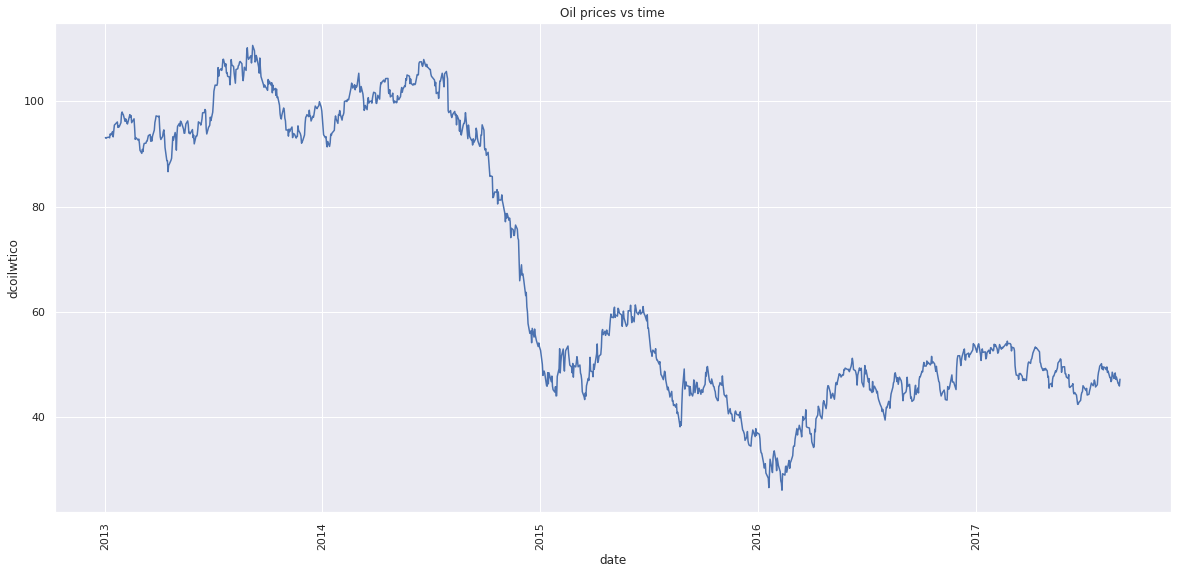

In [21]:
#Oil price variations
oil_data['date'] = pd.to_datetime(oil_data['date'], format = '%Y.%m.%d')
oil_data['Year Month'] = oil_data['date'].apply(lambda x:x.strftime('%Y[] %m'))

sns.set(rc = {'figure.figsize':(20,9)})
sns.lineplot(data = oil_data,x='date',y='dcoilwtico').set_title('Oil prices vs time')
plt.xticks(rotation=90);

In [22]:
df = train_data.groupby(['date','store_nbr'],as_index=False).agg({'sales':'sum'})
df = pd.merge(df,transactions_data,how='left',left_on=['date','store_nbr'],right_on=['date','store_nbr'])
df['transactions'] = df['transactions'].fillna(0)
df['Year Month'] = df['date'].apply(lambda x:x.strftime('%Y %m'))

In [23]:
df_all = df.groupby(['Year Month','store_nbr'],as_index=False).agg({'sales' : 'sum', 'transactions' : 'sum'})

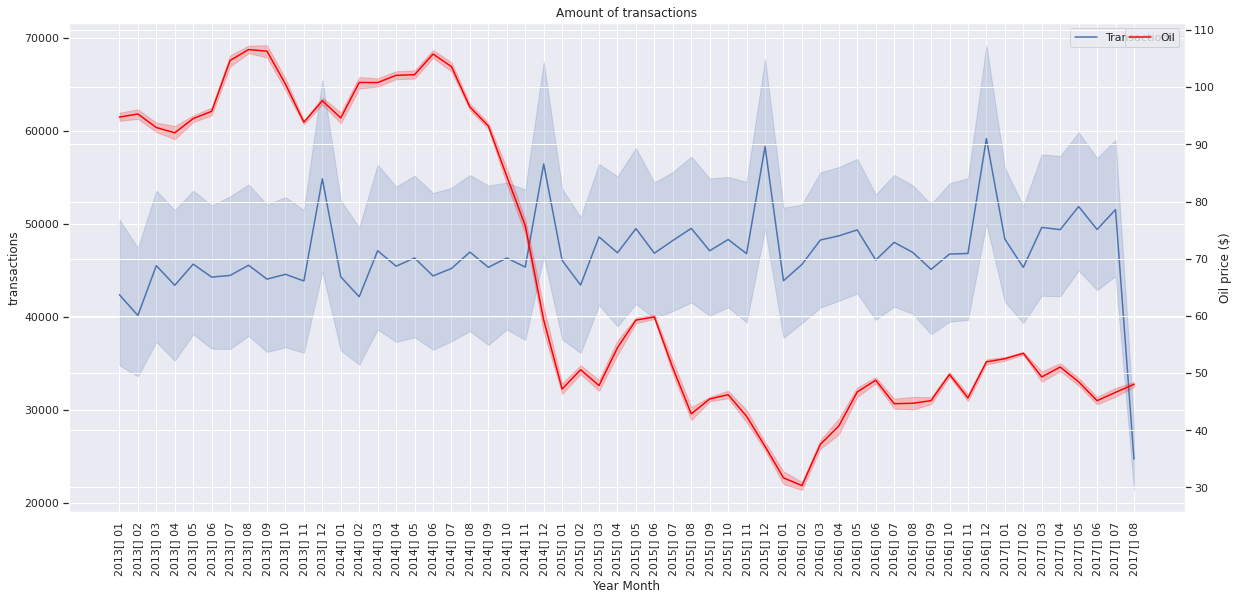

In [24]:
#The relationship between number of transactions and oil price
fig, ax = plt.subplots()
sns.set(rc = {'figure.figsize':(20,9)})
sns.lineplot(data = df_all,x='Year Month',y='transactions',ax=ax,label='Transactions').set_title('Amount of transactions')
plt.xticks(rotation = 90);
ax2 = ax.twinx()
sns.lineplot(data = oil_data,x='Year Month',y='dcoilwtico',ax=ax2,color='red',label='Oil')
ax2.set_ylabel('Oil price ($)')
ax2.legend(loc=0)

# FINDINGS:
- Total amount of sales and transactions increased in years 2013 - 2017. The number of shops increased by 9 between years 2013 - 20
- Number of sales and transactions is dependant on the oil price, as explained in competition. This is illustrated in the figure above.

<BarContainer object of 33 artists>

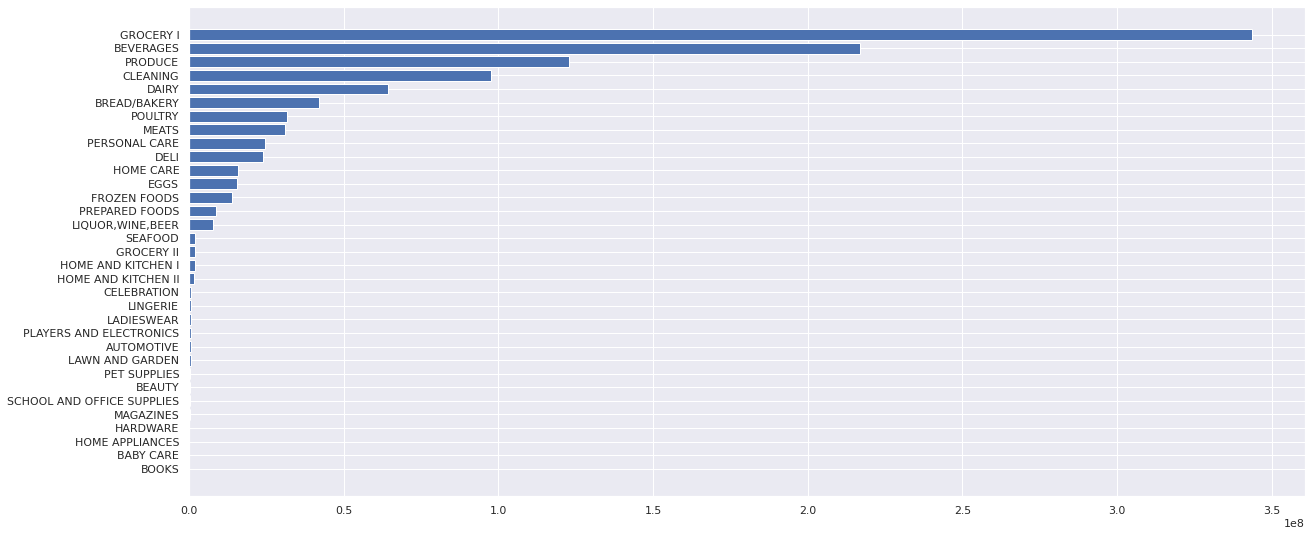

In [25]:
''' As suggested in this notebook by XODEUM https://www.kaggle.com/code/xodeum/advanced-store-sales-by-time-series'''
#Products by family
df = train_data.groupby('family').agg({'sales':'sum'}).sort_values(by='sales').reset_index()
plt.barh(df['family'],width=df['sales'])

# PRE-PROCESSING

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

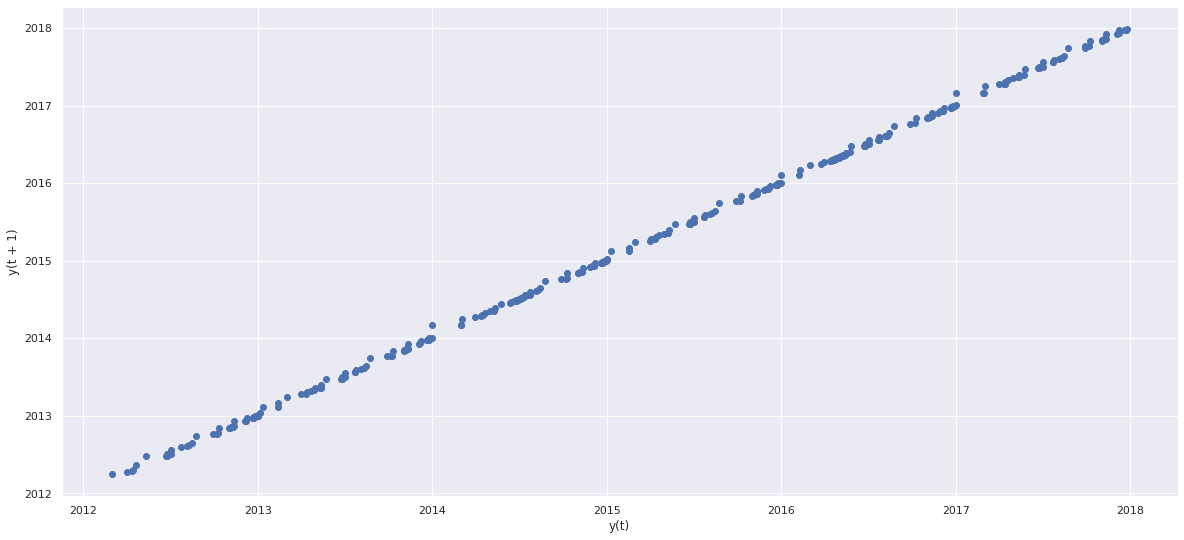

In [26]:
# Creating lag plot for the datasets
'''This is employed folowing '''
from pandas.plotting import lag_plot
lag_plot(holidays_data['date'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

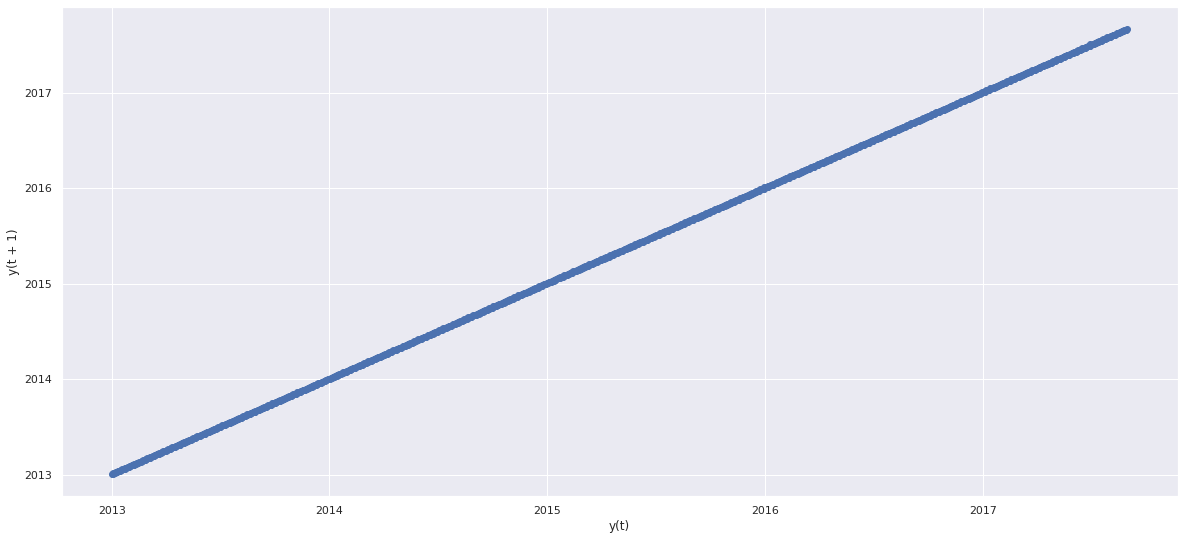

In [27]:
lag_plot(oil_data['date'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

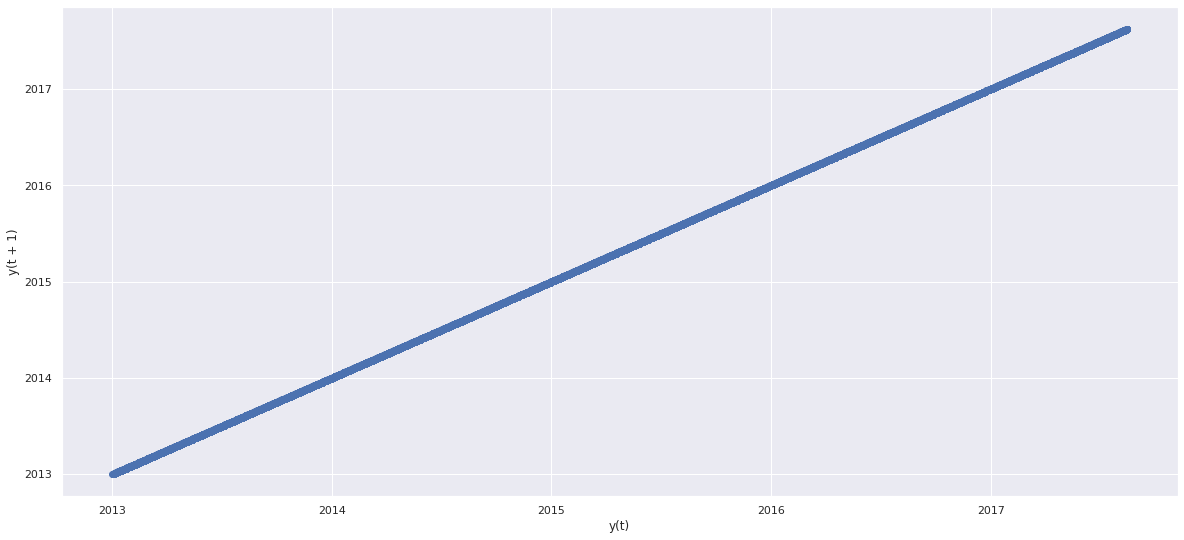

In [28]:
lag_plot(transactions_data['date'])

Hence, data has linear structure.

## Plotting partial autocorrelation

In [29]:
import matplotlib.dates as mpl_dates
holidays_data['date'] = holidays_data['date'].apply(mpl_dates.date2num)
holidays_data['date'] = holidays_data['date'].astype(float)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

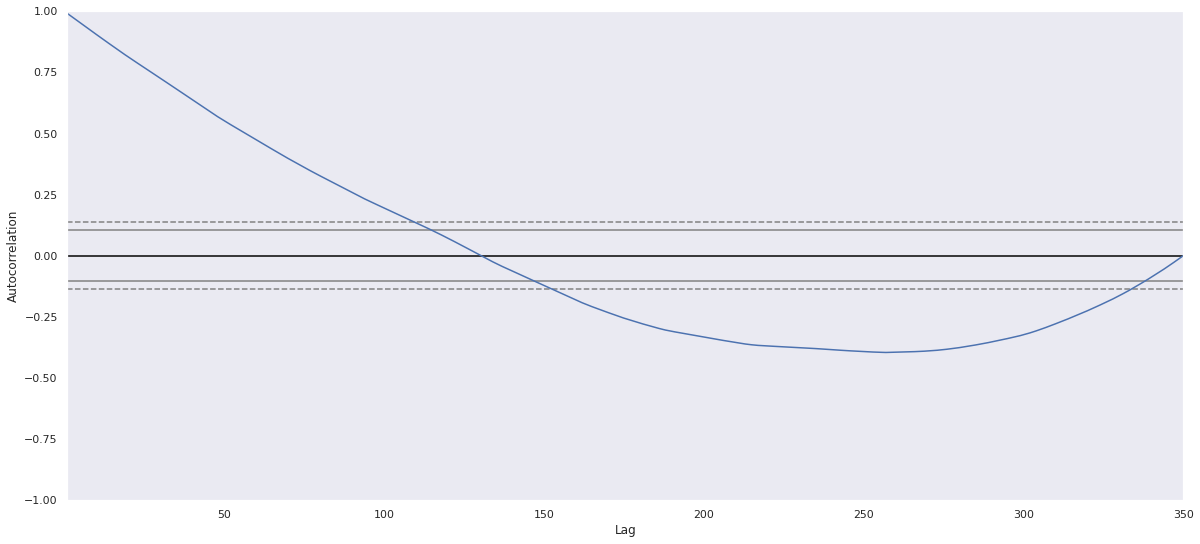

In [30]:
pd.plotting.autocorrelation_plot(holidays_data['date'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

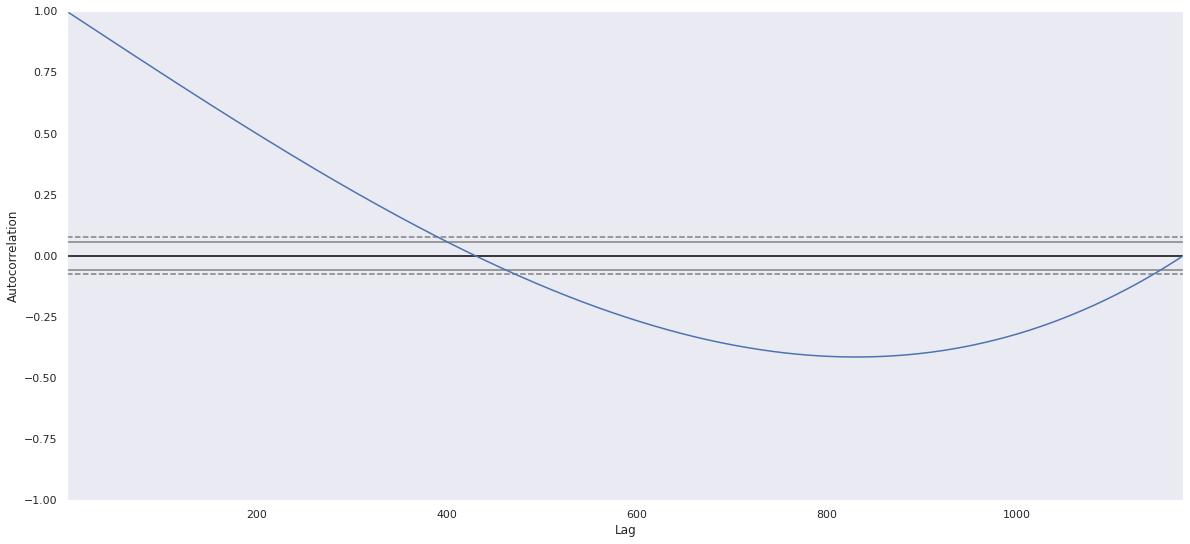

In [31]:
oil_data['date'] = oil_data['date'].apply(mpl_dates.date2num)
oil_data['date'] = oil_data['date'].astype(float)
pd.plotting.autocorrelation_plot(oil_data['date'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

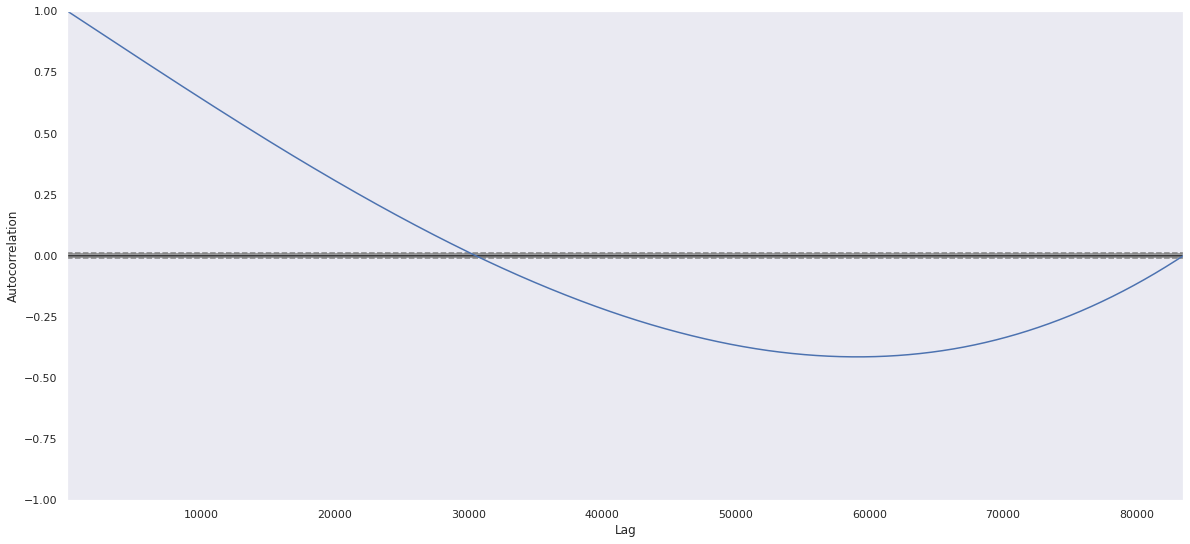

In [32]:
transactions_data['date'] = transactions_data['date'].apply(mpl_dates.date2num)
transactions_data['date'] = transactions_data['date'].astype(float)
pd.plotting.autocorrelation_plot(transactions_data['date'])

ACF helps to assess the properties of time series. 

From the plots above, it can be deducted that:
- Time series are not stationary, white-noise signal
- There is no seasonality in the data

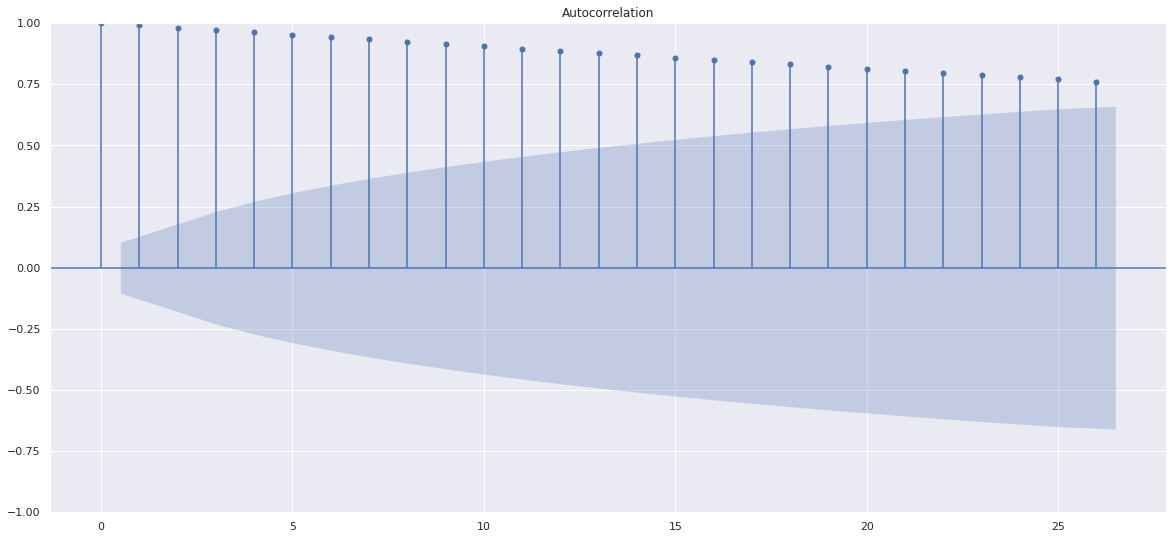

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(holidays_data['date']);

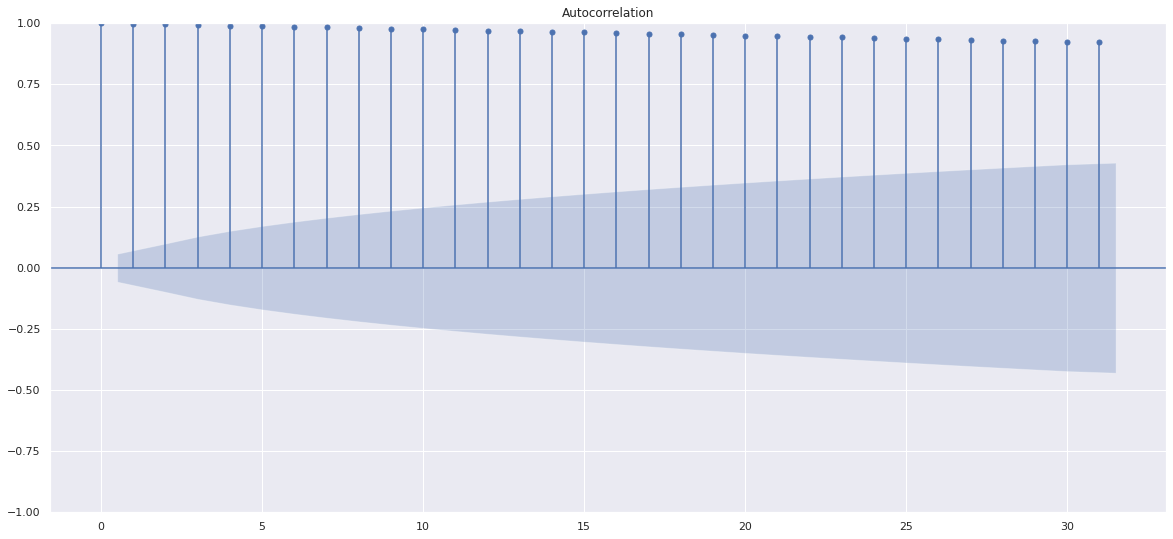

In [34]:
plot_acf(oil_data['date']);

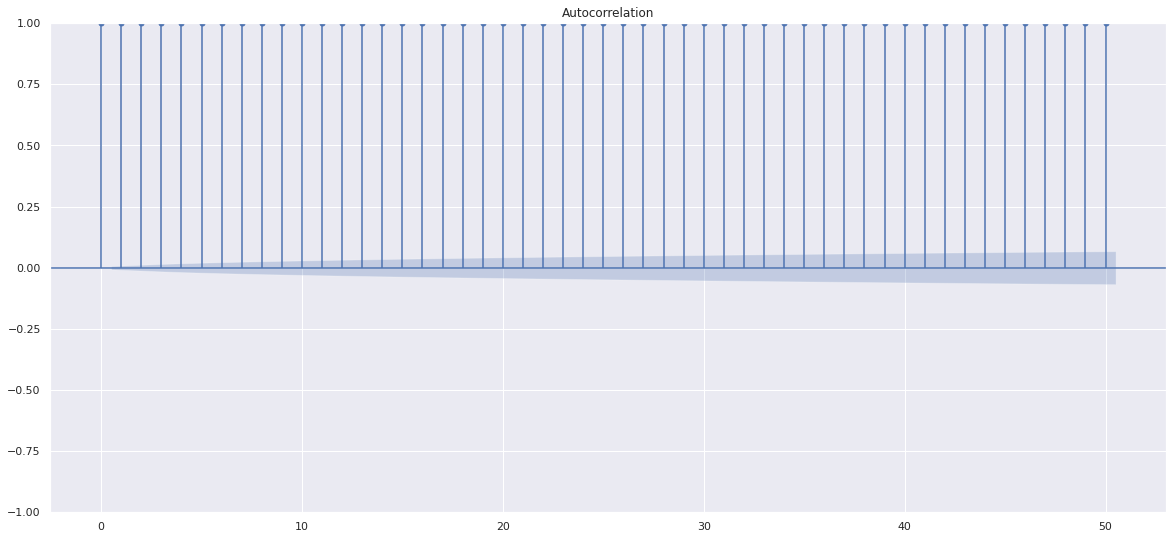

In [35]:
plot_acf(transactions_data['date']);

In [36]:
from statsmodels.graphics.tsaplots import plot_pacf

PACF only displays the correlation between observations that the shorter lags do not explain. Hence, more useful for specifying autoregressive model.

The PACF suggests fitting a second autoregressive models (partial correlations for lags 1 and 2 statistically significant in all the data)

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



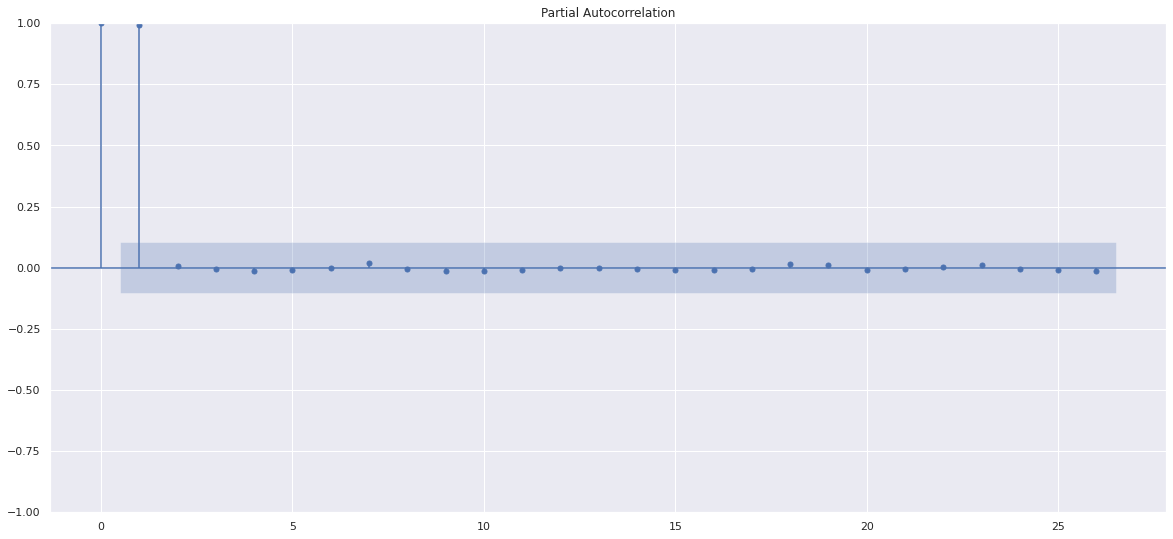

In [37]:
plot_pacf(holidays_data['date']);

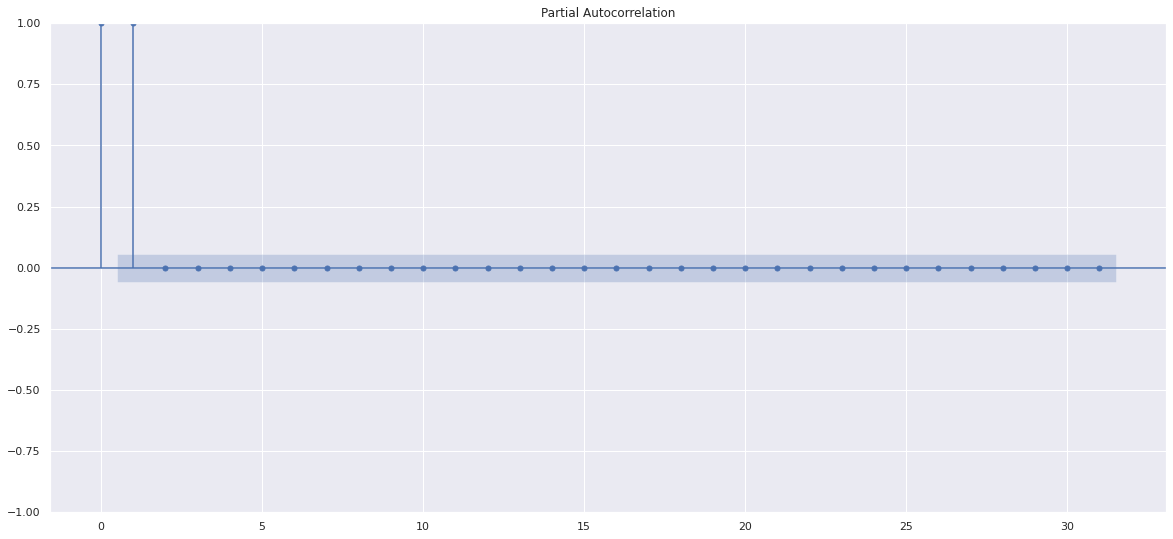

In [38]:
plot_pacf(oil_data['date']);

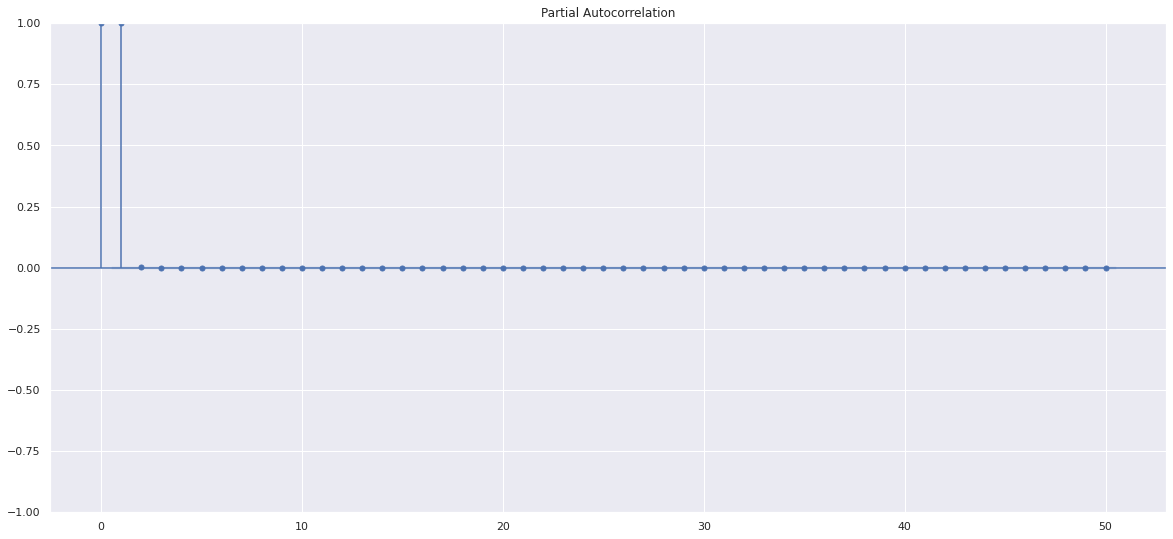

In [39]:
plot_pacf(transactions_data['date']);

The lags plot suggests that relation between the amount of sales to lags is linear. Partial autocorrelation suggests that the dependence can be captured using lags 1, 2. Those partial correlations are justifiable. Consumption trends month-by-month are likely to be closely related to each other.

# Autoregression

In [40]:
from statsmodels.tsa.ar_model import AutoReg

In [41]:
model0 = AutoReg(holidays_data['date'],1)
model_fit0 = model0.fit()
model_fit0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   date   No. Observations:                  350
Model:                     AutoReg(1)   Log Likelihood               -1273.780
Method:               Conditional MLE   S.D. of innovations              9.308
Date:                Sun, 10 Jul 2022   AIC                           2553.559
Time:                        17:15:45   BIC                           2565.124
Sample:                             1   HQIC                          2558.163
                                  350                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.7424     14.174      2.381      0.017       5.962      61.523
date.L1        0.9983      0.001   1166.126      0.000       0.997       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0017           +0.0000j            1.0017            0.0000
-----------------------------------------------------------------------------
"""

In [42]:
model1 = AutoReg(oil_data['date'],1)
model_fit1 = model1.fit()
model_fit1.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   date   No. Observations:                 1175
Model:                     AutoReg(1)   Log Likelihood               -1516.654
Method:               Conditional MLE   S.D. of innovations              0.881
Date:                Sun, 10 Jul 2022   AIC                           3039.308
Time:                        17:15:45   BIC                           3054.512
Sample:                             1   HQIC                          3045.041
                                 1175                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4525      0.866      1.677      0.094      -0.245       3.150
date.L1        1.0000   5.23e-05   1.91e+04      0.000       1.000       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [43]:
model2 = AutoReg(transactions_data['date'],1)
model_fit2 = model2.fit()
model_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   date   No. Observations:                83488
Model:                     AutoReg(1)   Log Likelihood               44962.067
Method:               Conditional MLE   S.D. of innovations              0.141
Date:                Sun, 10 Jul 2022   AIC                         -89918.135
Time:                        17:15:45   BIC                         -89890.137
Sample:                             1   HQIC                        -89909.569
                                83488                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0579      0.017      3.477      0.001       0.025       0.090
date.L1        1.0000      1e-06   9.97e+05      0.000       1.000       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

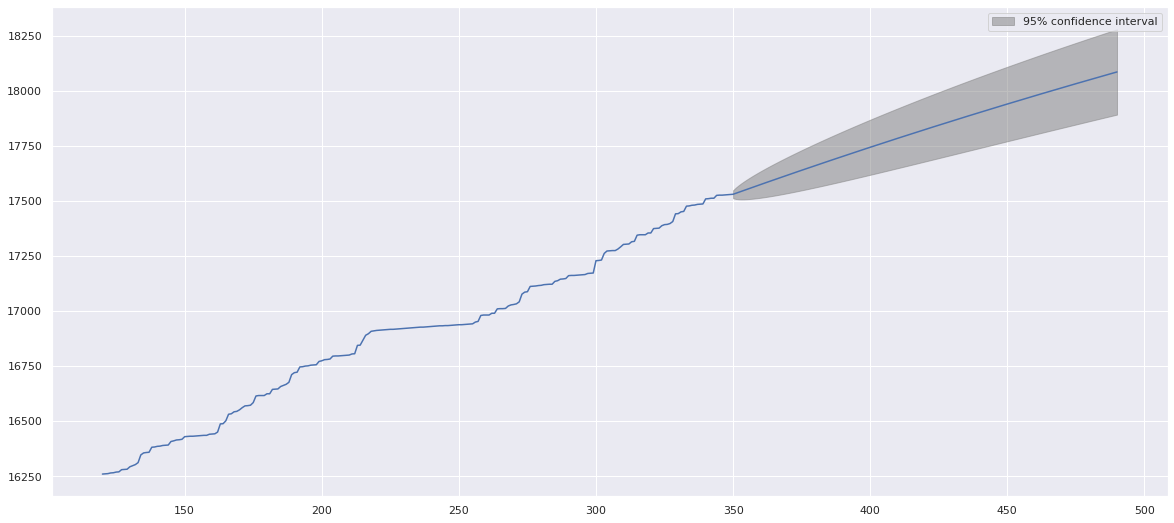

In [44]:
figure = model_fit0.plot_predict(120, 490,in_sample=True)

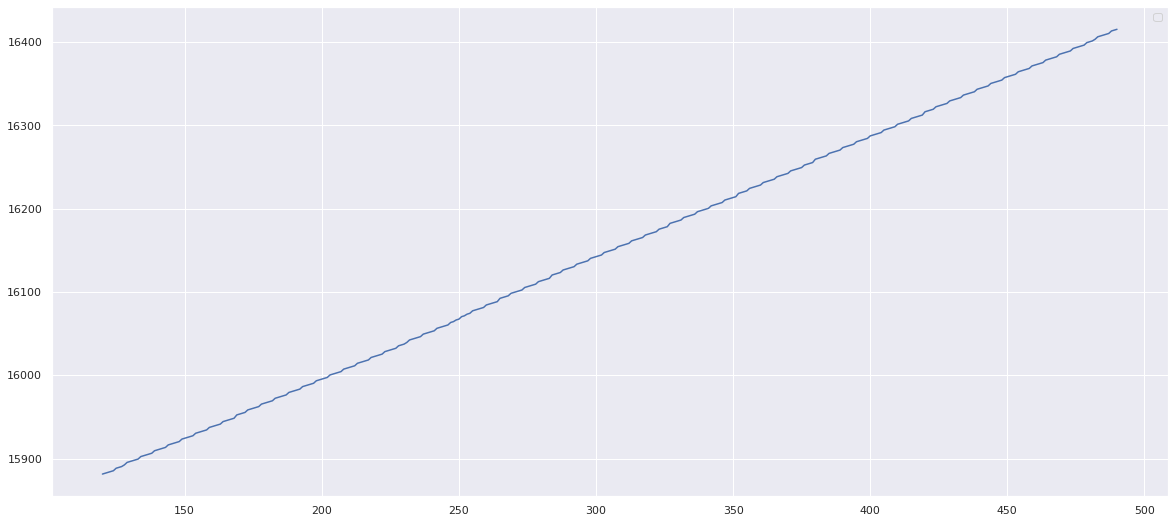

In [45]:
figure = model_fit1.plot_predict(120, 490)

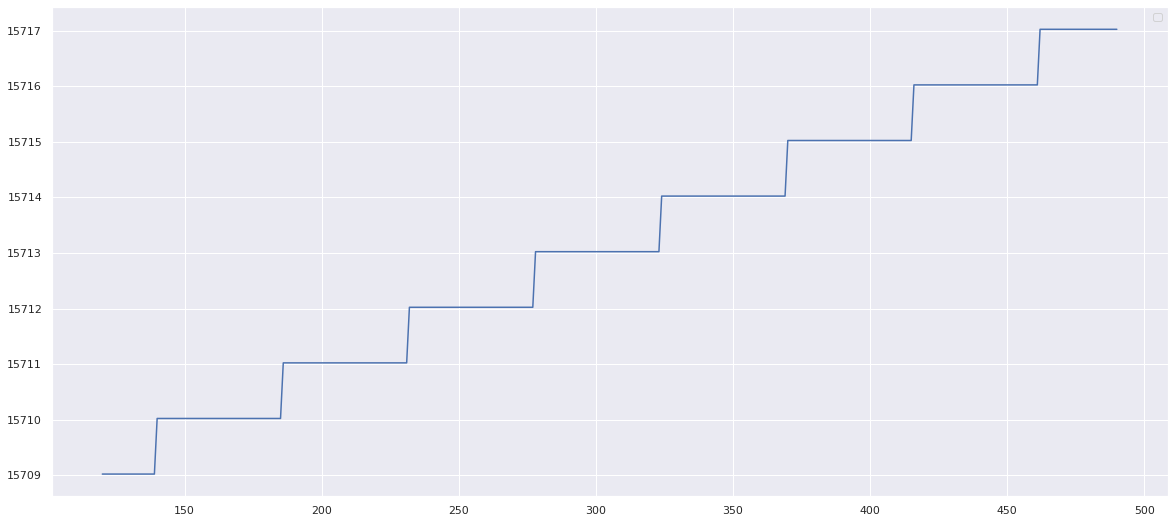

In [46]:
figure = model_fit2.plot_predict(120, 490)

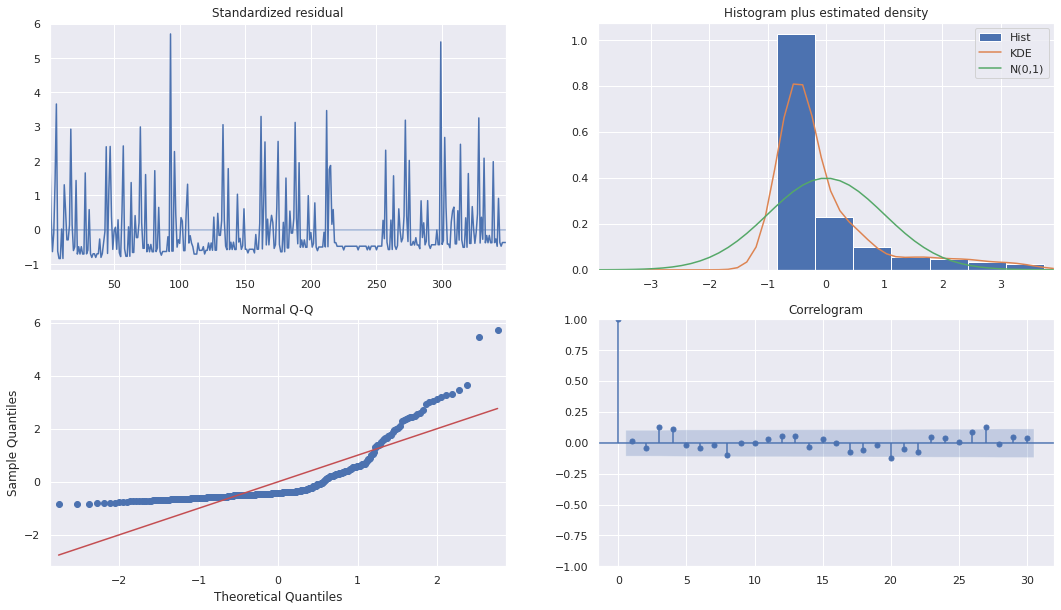

In [47]:
fig = plt.figure (figsize = (18, 10))
fig = model_fit0.plot_diagnostics(fig = fig, lags = 30)